# Poisson Processes

In [1]:
include("utils.jl"); using .Utils
checkpkgs("Distributions", "LaTeXStrings", "Plots")

## The World Cup Problem

## The Poisson Distribution

In [2]:
using Distributions

λ=1.4
dist = Poisson(λ)
typeof(dist)

Poisson{Float64}

In [3]:
k=4
pdf(dist, k)

0.039471954028253146

In [4]:
include("empiricaldist.jl"); using .EmpiricalDist

"""Make a Pmf of a Poisson distribution."""
function make_poisson_pmf(λ, qs)
    ps = pdf.(Poisson(λ), qs)
    pmf = Pmf(ps, qs)
    normalize!(pmf)
    return pmf
end

make_poisson_pmf

In [5]:
lam = 1.4
goals = 0:9
pmf_goals = make_poisson_pmf(lam, goals);

In [6]:
function decorate_goals!(title="")
    xlabel!("Number of goals")
    ylabel!("PMF")
    title!(title)
end

decorate_goals! (generic function with 2 methods)

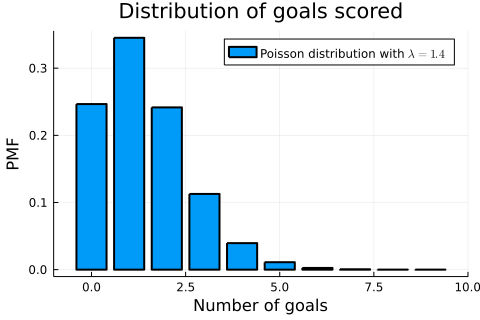

In [7]:
using LaTeXStrings, Plots
bar(pmf_goals, label=L"Poisson distribution with $\lambda=1.4$")
decorate_goals!("Distribution of goals scored")

## The Gamma Distribution

In [8]:
α = 1.4
qs = LinRange(0, 10, 101)
ps = pdf.(Gamma(α),qs);

In [9]:
prior = Pmf(ps, qs)
normalize!(prior)

9.889360237140306

In [10]:
function decorate_rate!(title="")
    xlabel!("Goal scoring rate (lam)")
    ylabel!("PMF")
    title!(title)
end

decorate_rate! (generic function with 2 methods)

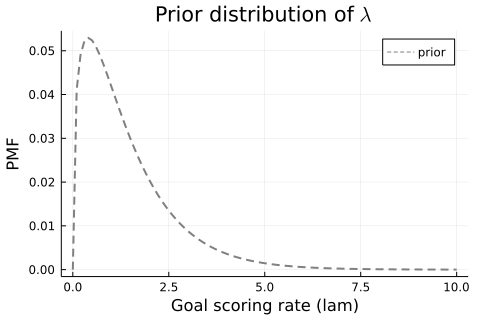

In [11]:
plot(prior, style=:dash, label="prior", color=:gray)
decorate_rate!(L"Prior distribution of $\lambda$") # does not render correctly

In [12]:
mean(prior)

1.4140818156118378

## The Update

In [13]:
λ = 1.4
k = 4
pdf.(Poisson(λ), 4)

0.039471954028253146

In [14]:
lams = prior.qs
k=4
likelihood = pdf.(Poisson.(lams), k);

In [15]:
"""Update Pmf with a Poisson likelihood."""
function update_poisson!(pmf, data)
    k=data
    lams = pmf.qs
    likelihood = pdf.(Poisson.(lams), k)
    pmf .*= likelihood
    normalize!(pmf)
end

update_poisson!

In [16]:
france = copy(prior)
update_poisson!(france, 4);

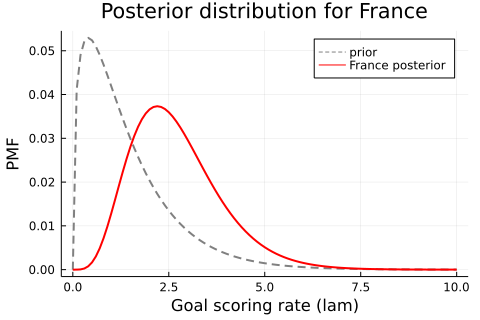

In [17]:
plot(prior, style=:dash, label="prior", color=:gray)
plot!(france, label="France posterior", color=:red)

decorate_rate!("Posterior distribution for France")

In [18]:
croatia = copy(prior)
update_poisson!(croatia, 2);

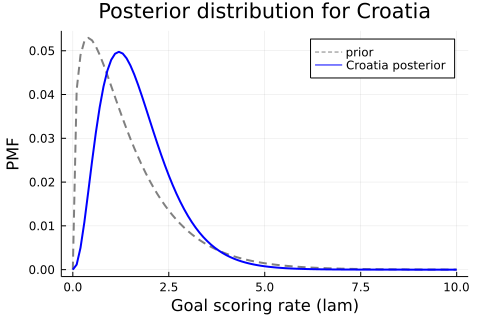

In [19]:
plot(prior, style=:dash, label="prior", color=:gray)
plot!(croatia, label="Croatia posterior", color=:blue)

decorate_rate!("Posterior distribution for Croatia")

In [20]:
println(mean(croatia), " ",mean(france))

1.6999765866755212 2.699772393342307


## Probability of Superiority

In [21]:
"""Compute the probability of superiority."""
function my_prob_gt(pmf1, pmf2) # renamed: prob_gt() in empiricaldist
    total = 0
    for (q1, p1) in zip(pmf1.qs, pmf1.ps)
        for (q2, p2) in zip(pmf2.qs, pmf2.ps)
            if q1 > q2
                total += p1 * p2
            end
        end
    end
    return total
end

my_prob_gt

In [22]:
my_prob_gt(france, croatia)

0.7499366290930146

In [23]:
prob_gt(france, croatia)

0.7499366290930163

## Predicting the Rematch

In [24]:
pmf_seq = [make_poisson_pmf(lam, goals) 
           for lam in prior.qs];

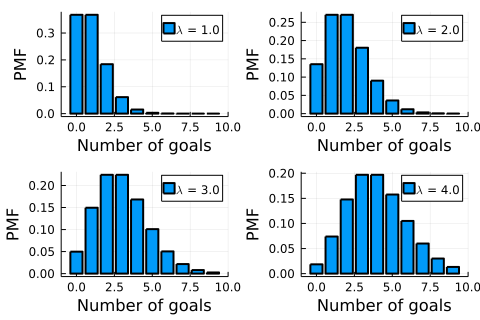

In [25]:
bars = []
for index in [10, 20, 30, 40]
    lam = prior.qs[index+1] # Arrays in Julia are 1-based
    pmf = pmf_seq[index+1]
    push!(bars, bar(pmf, label=L"$\lambda$ = %$(lam)"))
end
plot(bars...)
decorate_goals!()

In [26]:
pred_france = makemixture(france, pmf_seq);

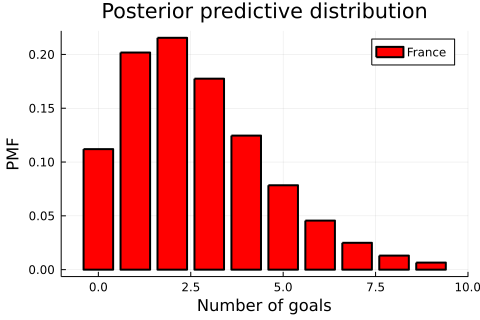

In [27]:
bar(pred_france, label="France", color=:red)
decorate_goals!("Posterior predictive distribution")

In [28]:
pred_croatia = makemixture(croatia, pmf_seq);

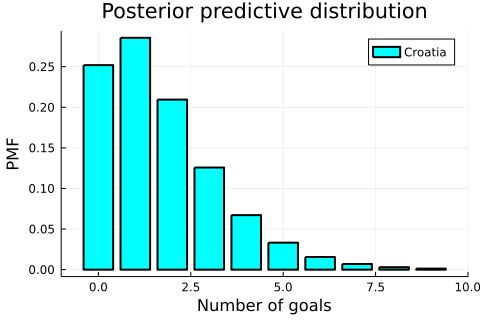

In [29]:
bar(pred_croatia, label="Croatia", color=:cyan)
decorate_goals!("Posterior predictive distribution")

In [30]:
win = prob_gt(pred_france, pred_croatia)
win

0.5703522415934511

In [31]:
lose = prob_lt(pred_france, pred_croatia)
lose

0.26443376257235846

In [32]:
tie = prob_eq(pred_france, pred_croatia)
tie

0.16521399583418925

In [33]:
win + tie/2

0.6529592395105457

## The Exponential Distribution

In [34]:
"""Compute the PDF of the exponential distribution."""
@. expo_pdf(t, λ) = λ * exp(-λ * t) # @. adds vector/broadcast support

# Julia uses θ=1/λ as parameter, so we could also define:
#   expo_pdf(t, λ) = pdf(Exponential(1/λ), t)

expo_pdf

In [35]:
lam = 1.4
qs = LinRange(0, 4, 101)
ps = expo_pdf(qs, lam)
pmf_time = Pmf(ps, qs)
normalize!(pmf_time)

25.616650745459076

In [36]:
function decorate_time!(title="")
    xlabel!("Time between goals (games)")
    ylabel!("PMF")
    title!(title)
end

decorate_time! (generic function with 2 methods)

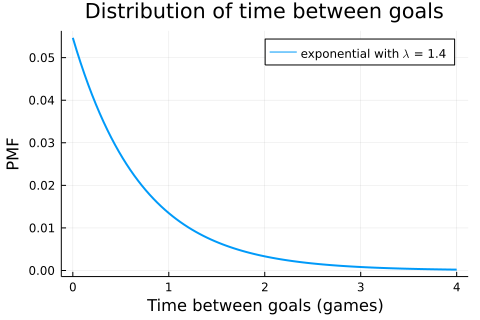

In [37]:
plot(pmf_time, label=L"exponential with $\lambda$ = 1.4")
decorate_time!("Distribution of time between goals")

## Summary

## Exercises

In [38]:
# 8.1
function update_expo!(pmf, data)
    t=data/90
    lams = pmf.qs
    likelihood = pdf.(Exponential.(1 ./ lams), t)
    pmf .*= likelihood
    normalize!(pmf)
end

# prior
α = 1.4
qs = LinRange(0, 10, 101)
ps = pdf.(Gamma(α),qs);
prior = Pmf(ps, qs)
normalize!(prior)

germany = copy(prior)
update_expo!(germany, 11)

germany2 = copy(germany)
update_expo!(germany2, 12)

1.4598709349606893

In [39]:
mean(germany), mean(germany2)

(2.135888265308687, 2.703059034926364)

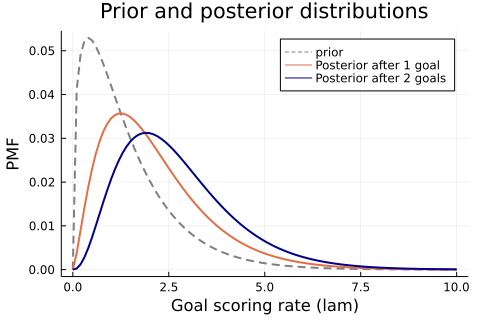

In [40]:
plot(prior, style=:dash, label="prior", color=:gray)
plot!(germany, label="Posterior after 1 goal")
plot!(germany2, label="Posterior after 2 goals", color=:darkblue)

decorate_rate!("Prior and posterior distributions")

In [41]:
t = (90-23) / 90

pmf_seq = [make_poisson_pmf(lam*t, goals) 
           for lam in germany2.qs];

In [42]:
pred_germany2 = makemixture(germany2, pmf_seq);

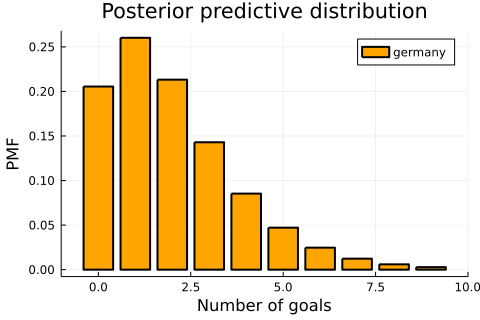

In [43]:
bar(pred_germany2, label="germany", color=:orange)
decorate_goals!("Posterior predictive distribution")

In [44]:
pred_germany2[5]

0.04710965870611341

In [45]:
prob_ge(pred_germany2, 5)

0.0928620012283454

In [46]:
# 8.2

"""
Make a PMF of an exponential distribution.
    
lam: event rate
high: upper bound on the interval `t`
    
returns: Pmf of the interval between events
"""
function make_expo_pmf(lam, high)
    qs = LinRange(0, high, 101)
    ps = pdf.(Exponential.(1 ./ lam), qs)
    pmf = Pmf(ps, qs)
    normalize!(pmf)
    return pmf
end
make_expo_pmf(lam; high) = make_expo_pmf(lam, high)

make_expo_pmf (generic function with 2 methods)

In [47]:
pmf_seq = [make_expo_pmf(lam, high=4) for lam in prior.qs];

In [48]:
pred_france = makemixture(france, pmf_seq)
pred_croatia = makemixture(croatia, pmf_seq);

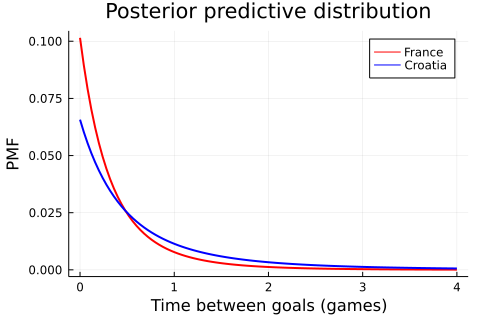

In [49]:

plot(pred_france, label="France", color=:red)
plot!(pred_croatia, label="Croatia", color=:blue)

decorate_time!("Posterior predictive distribution")

In [50]:
prob_lt(pred_france, pred_croatia)

0.5904596116867535

In [51]:
# 8.3

α = 2.8
qs = LinRange(0, 15, 101)
ps = pdf.(Gamma(α), qs)
prior_hockey = Pmf(ps, qs)
normalize!(prior_hockey)

6.666325137469513

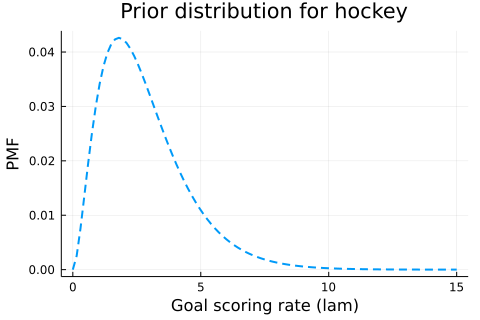

In [52]:
plot(prior_hockey, style=:dash)
decorate_rate!("Prior distribution for hockey")

In [53]:
mean(prior_hockey)

2.7997400090376576

In [54]:
bruins = copy(prior_hockey)
for data in [0, 2, 8, 4]
    update_poisson!(bruins, data)
end
mean(bruins)

3.3599999999999963

In [55]:
canucks = copy(prior_hockey)
for data in [1, 3, 1, 0]
    update_poisson!(canucks, data)
end
mean(canucks)

1.5599999606443664

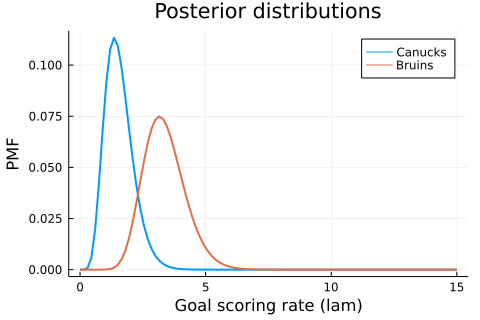

In [56]:
plot(canucks, label="Canucks")
plot!(bruins, label="Bruins")

decorate_rate!("Posterior distributions")

In [57]:
goals = 0:14
pmf_seq = [make_poisson_pmf(λ, goals) for λ in bruins.qs];

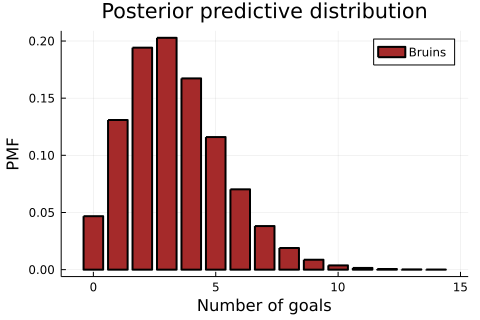

In [58]:
pred_bruins = makemixture(bruins, pmf_seq)

bar(pred_bruins, label="Bruins", color=:brown)
decorate_goals!("Posterior predictive distribution")

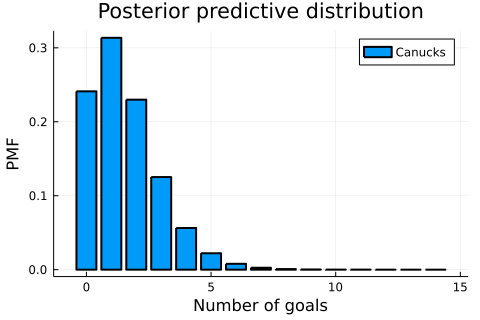

In [59]:
pred_canucks = makemixture(canucks, pmf_seq)

bar(pred_canucks, label="Canucks")
decorate_goals!("Posterior predictive distribution")

In [60]:

win = prob_gt(pred_bruins, pred_canucks)
lose = prob_lt(pred_bruins, pred_canucks)
tie = prob_eq(pred_bruins, pred_canucks)

win, lose, tie

(0.7038631514645921, 0.16111690750716454, 0.13501994102824283)

In [61]:
p = win + tie/2
p

0.7713731219787135

In [62]:
n = 3
a = pdf.(Binomial(n,p), [2, 3])
sum(a)

0.8670900197850082